In [1]:
#import packages and functions
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import os
import fiona
import shapely

from general_functions import *
pd.set_option('display.max_columns', None)


# Wetterskip Fryslan

In [2]:
gpkg_path_Wetterskip = "..\..\Data_preprocessed\Waterschappen\Wetterskip\Wetterskip_gecorrigeerde_geometrie.gpkg"
output_gpkg_path_Wetterskip = "../../Data_postprocessed/Waterschappen/Wetterskip/Wetterskip"

# peilgebiedpraktijk_path = r"D:\Users\Bruijns\Documents\PR4750_20\Data_preprocessed\Waterschappen\Wetterskip\Nieuwe_peilgebieden\MIPWA_20230907WF.gpkg"
# streefpeil_path = r"D:\Users\Bruijns\Documents\PR4750_20\Data_preprocessed\Waterschappen\Wetterskip\Nieuwe_peilgebieden\MIPWA_20230907WF.gpkg"
peilgebieden_path = r"D:\Users\Bruijns\Documents\PR4750_20\Data_preprocessed\Waterschappen\Wetterskip\Peilenkaart_HKV_20240411\Peilenkaart.gdb"

In [3]:
# Duikersifonhevel and hydroobject have a type of multicurvedZ, the peilgebieden a MultiSurfaceZ, which geopandas can not handle. I have manually 
# exported these to single shapes, which automatically converts it to regular MultiStrings. Then these layers have been packed together to a
# geopackage again. 

#retrieve the data
Wetterskip = read_gpkg_layers(gpkg_path = gpkg_path_Wetterskip, 
                        variables = ['stuw', 
                                     'gemaal', 
                                     'afsluitmiddel',
                                     'hydroobject',
                                     'duikersifonhevel'],
                                     # 'peilmerk',
                                     # 'streefpeil',
                                     # 'peilgebiedpraktijk', 
                                     # 'peilgebiedvigerend',
                                     # 'peilbesluitgebied'],
                        print_var = False)

# #The peilgebieden en streefpeilen have been delivered as additional data
# peilgebiedpraktijk = gpd.read_file(peilgebiedpraktijk_path,
#                                    layer = 'DAMO_W_PeilgebiedPraktijk')

# streefpeil = gpd.read_file(streefpeil_path,
#                            layer = 'DAMO_W_Streefpeil')

Wetterskip['hydroobject'] = Wetterskip['hydroobject'].loc[Wetterskip['hydroobject'].categorieo == 'primair'] #feedback WS Fryslan: only use primaire hydroobjecten

## Additional schouwsloten near a gemaal

In [4]:
schouwsloten = gpd.read_file(r"D:\Users\Bruijns\Documents\PR4750_20\Data_preprocessed\Waterschappen\Wetterskip\20240610_extra_hydroobjecten\schouwsloten\schouwsloten_gemaal5m.shp")


In [5]:
schouwsloten['code'] = schouwsloten['OVKIDENT']
schouwsloten['nen3610id'] = 'dummy_code_schouwsloot_' + schouwsloten.index.astype(str)
schouwsloten['globalid'] = 'dummy_code_schouwsloot_' + schouwsloten.index.astype(str)
schouwsloten = schouwsloten[['code', 'nen3610id', 'globalid', 'geometry']]

In [6]:
peilgebied = gpd.read_file(peilgebieden_path)

#add an additionally deliverd peilgebied to the peilgebieden
Willem_jongsma = gpd.read_file(r"D:\Users\Bruijns\Documents\PR4750_20\Data_preprocessed\Waterschappen\Wetterskip\20240618_Willem_Jongsma_polder\WF_Willem_Jongsma.shp")

#in the same format
Willem_jongsma['GPGIDENT'] = Willem_jongsma.PBHIDENT
Willem_jongsma['GPGZMRPL'] = Willem_jongsma.LAAGPEIL
Willem_jongsma['OSMOMSCH'] = Willem_jongsma.WATERSYSTE
Willem_jongsma['GLOBALID'] = Willem_jongsma.ORDECODE + '_' + Willem_jongsma.index.astype(str)

peilgebied = pd.concat([peilgebied, Willem_jongsma])

peilgebied['waterhoogte'] = np.nan
peilgebied['waterhoogte'].fillna(value = peilgebied['GPGZMRPL'], inplace = True) #first check the zomerpeil
peilgebied['waterhoogte'].fillna(value = peilgebied['IWS_GPGVASTP'], inplace = True) #then the vastpeil
peilgebied['waterhoogte'].fillna(value = peilgebied['GPGWNTPL'], inplace = True) #lastly, the winterpeil

In [7]:
peilgebied.tail()

,GPGIDENT,GPGNAAM,GPGSOORT,GPGOPPVL,GPGZMRPL,OPVAFWZP,GPGWNTPL,OPVAFWWP,OSMOMSCH,IWS_GPGSTATU,IWS_GPGINVO,IWS_GPGSCHWP,IWS_GPGBEHER,IWS_GPGVASTP,IWS_GPGAFWVASTP,IWS_GPGONDP,IWS_GPGBOVP,IWS_GPGAFWONDP,IWS_GPGAFWBOVP,IWS_INUNDATIEPEIL,IWS_ONDERGRENS_ZOMERPEIL,IWS_BOVENGRENS_ZOMERPEIL,RICHTING,IWS_MEMO,GEONAUWKEURIGHEID,ADMINNAUWKEURIGHEID,BETROUWBAARHEID,INWINNINGSWIJZE,INWINNINGSDATUM,BRON,IDEALISATIE,OPMERKINGEN,GEONAUWKEURIGHEID_Z,IWS_KWLTGEO,IWS_EIGENAAR,GLOBALID,WF_INWERKINGTREDING_DATUM,Shape_Length,Shape_Area,geometry,PBHIDENT,TYPEBEHEER,HOOGPEIL,LAAGPEIL,AFW_PEILBE,AFW_HOOGPE,AFW_LAAGPE,VERGUNNING,WATERSYSTE,AANVOER_AF,TYPEPEILVA,OPMERKING,AFW_EIND,AANVOER_MO,ORDECODE,LAST_EDITE,LAST_EDI_1,HOOGWATERC,SHAPE_AREA,waterhoogte
34,PBH0254883,NaN,NaN,NaN,-0.75,NaN,NaN,NaN,Willem Jongsma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,WZ.401.001_34,NaT,NaN,NaN,"POLYGON Z ((189308.409 540865.901 0.000, 18930...",PBH0254883,3.0,-0.55,-0.75,1.0,0.0,0.0,None,Willem Jongsma,1.0,3.0,None,None,1.0,WZ.401.001,MKODDEN,2024-03-26,None,0.389727,-0.75
35,PBH0254876,NaN,NaN,NaN,-0.55,NaN,NaN,NaN,Willem Jongsma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,WZ.401.001_35,NaT,NaN,NaN,"POLYGON Z ((191521.683 539320.110 0.000, 19163...",PBH0254876,1.0,-0.55,-0.55,1.0,0.0,0.0,None,Willem Jongsma,1.0,3.0,None,None,1.0,WZ.401.001,MKODDEN,2024-03-26,None,79928.585636,-0.55
36,PBH0254901,NaN,NaN,NaN,-1.20,NaN,NaN,NaN,Willem Jongsma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,WZ.401.001_36,NaT,NaN,NaN,"POLYGON Z ((190787.267 540064.328 0.000, 19081...",PBH0254901,1.0,-1.20,-1.20,1.0,0.0,0.0,None,Willem Jongsma,3.0,3.0,None,None,1.0,WZ.401.001,MKODDEN,2024-03-26,None,131878.257601,-1.20
37,PBH0254905,NaN,NaN,NaN,-1.20,NaN,NaN,NaN,Willem Jongsma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,WZ.401.001_37,NaT,NaN,NaN,"POLYGON Z ((190972.562 540027.516 0.000, 19093...",PBH0254905,1.0,-1.20,-1.20,1.0,0.0,0.0,None,Willem Jongsma,2.0,3.0,None,None,1.0,WZ.401.001,MKODDEN,2024-03-26,None,3031.453042,-1.20
38,PBH0254925,NaN,NaN,NaN,-1.25,NaN,NaN,NaN,Willem Jongsma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,WZ.401.001_38,NaT,NaN,NaN,"POLYGON Z ((189453.748 540955.695 0.000, 18943...",PBH0254925,1.0,-1.25,-1.25,1.0,0.0,0.0,None,Willem Jongsma,3.0,3.0,None,None,1.0,WZ.401.001,MKODDEN,2024-03-26,None,11878.916225,-1.25


In [8]:
peilgebied['code'] = peilgebied['GPGIDENT']
peilgebied['nen3610id'] = peilgebied['OSMOMSCH'] + '_' + peilgebied.index.astype(str)
peilgebied['globalid'] = peilgebied['GLOBALID'] 

peilgebied = peilgebied[['waterhoogte', 'code', 'nen3610id', 'globalid', 'geometry']]

<AxesSubplot:>

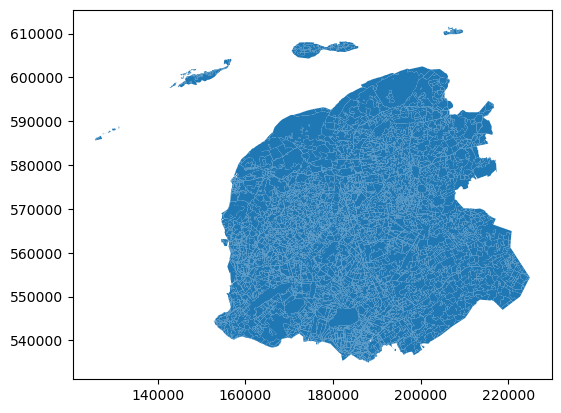

In [9]:
# #merge the streefpeil and the peilgebieden
# peilgebied = pd.merge(left = streefpeil,
#                   right = peilgebiedpraktijk,
#                   left_on = 'PEILGEBIEDPRAKTIJKID',
#                   right_on = 'GLOBALID')

# Wetterskip['peilgebied'] = peilgebied[['WATERHOOGTE', 'nen3610id_y', 'GLOBALID_y', 'geometry_y']]
# Wetterskip['peilgebied'] = Wetterskip['peilgebied'].rename(columns = {'WATERHOOGTE':'waterhoogte',
#                                                                       'nen3610id_y':'nen3610id',
#                                                                       'GLOBALID_y':'globalid',
#                                                                       'geometry_y':'geometry'})

Wetterskip['peilgebied'] = gpd.GeoDataFrame(peilgebied, geometry = 'geometry')
Wetterskip['peilgebied'].reset_index(drop=True, inplace = True)

Wetterskip['peilgebied'].plot()

In [10]:
aggregation_areas = gpd.read_file(peilgebieden_path)
aggregation_areas = pd.concat([aggregation_areas, Willem_jongsma])

aggregation_areas = aggregation_areas.dissolve(by='OSMOMSCH', as_index= False, dropna=False)

aggregation_areas['code'] = aggregation_areas.OSMOMSCH
aggregation_areas['globalid'] = aggregation_areas.GLOBALID
aggregation_areas['nen3610id'] = aggregation_areas.GPGIDENT

aggregation_areas = aggregation_areas[['code', 'nen3610id', 'globalid', 'geometry']]

Wetterskip['aggregation_area'] = aggregation_areas

In [11]:
def convert_3D_2D(geometry):
    '''
    Takes a GeoSeries of 3D Multi/Polygons (has_z) and returns a list of 2D Multi/Polygons
    '''
    new_geo = []
    for p in geometry:
        if p.has_z:
            if p.geom_type == 'Polygon':
                lines = [xy[:2] for xy in list(p.exterior.coords)]
                new_p = Polygon(lines)
                new_geo.append(new_p)
            elif p.geom_type == 'MultiPolygon':
                new_multi_p = []
                for ap in p:
                    lines = [xy[:2] for xy in list(ap.exterior.coords)]
                    new_p = Polygon(lines)
                    new_multi_p.append(new_p)
                new_geo.append(MultiPolygon(new_multi_p))
    return new_geo

def convert_to_polygon(line):
    if line.is_ring:  # Checks if the LineString is closed
        return Polygon(line)
    else:
        return line  # Returns the line string as is if it's not closed

from shapely import Polygon
from shapely.ops import unary_union,cascaded_union 


In [12]:
#select Vrijafstromende gebieden, and exclude it from the aggregation areas
Vrijafstromend = Wetterskip['aggregation_area'].loc[Wetterskip['aggregation_area'].code == 'Vrijafstromend'].explode(ignore_index=True)
Wetterskip['aggregation_area'] = Wetterskip['aggregation_area'].loc[Wetterskip['aggregation_area'].code != 'Vrijafstromend']
Wetterskip['aggregation_area'] = Wetterskip['aggregation_area'].loc[Wetterskip['aggregation_area'].code != 'Riolering']
Wetterskip['aggregation_area'] = Wetterskip['aggregation_area'].loc[Wetterskip['aggregation_area'].code != 'Zomerpolder']
Wetterskip['aggregation_area'] = Wetterskip['aggregation_area'].loc[Wetterskip['aggregation_area'].code != 'Vrijafstromend IJsselmeer']
Wetterskip['aggregation_area'] = Wetterskip['aggregation_area'].loc[Wetterskip['aggregation_area'].code != 'Boezem beheerst']
Wetterskip['aggregation_area'] = Wetterskip['aggregation_area'].loc[Wetterskip['aggregation_area'].code != 'Particulier']



#remove the boezem from the aggregation areas, as these should be handled seperatley to prevent it becoming a single and huge bucket
Wetterskip['aggregation_area'] = Wetterskip['aggregation_area'].loc[Wetterskip['aggregation_area'].code != 'Boezem']

#now identify each boezem peilgebied back in the peilgebieden, as it should still be filtered based on the boezem. Add it to the concat a few lines below
boezem_peilgebied = Wetterskip['peilgebied'].loc[Wetterskip['peilgebied'].nen3610id.str.contains('Boezem_')]#.plot()


#add additional numbers, due to the explosion
Vrijafstromend['code'] = Vrijafstromend['code'] + Vrijafstromend.index.astype(str)
Vrijafstromend['globalid'] = Vrijafstromend['globalid'] + Vrijafstromend.index.astype(str)
Vrijafstromend['nen3610id'] = Vrijafstromend['nen3610id'] + Vrijafstromend.index.astype(str)

#add the Vrijafstromende gebieden to the aggregation areas again
Wetterskip['aggregation_area'] = pd.concat([Wetterskip['aggregation_area'], Vrijafstromend, boezem_peilgebied])

In [13]:
Wetterskip['aggregation_area'].loc[Wetterskip['aggregation_area'].duplicated(subset='code'), 'code'] = Wetterskip['aggregation_area'].loc[Wetterskip['aggregation_area'].duplicated(subset='code')].code.astype(str) + '_' + Wetterskip['aggregation_area'].loc[Wetterskip['aggregation_area'].duplicated(subset='code')].index.astype(str)
Wetterskip['aggregation_area'].loc[Wetterskip['aggregation_area'].duplicated(subset='nen3610id'), 'nen3610id'] = Wetterskip['aggregation_area'].loc[Wetterskip['aggregation_area'].duplicated(subset='nen3610id')].nen3610id.astype(str) + '_' + Wetterskip['aggregation_area'].loc[Wetterskip['aggregation_area'].duplicated(subset='nen3610id')].index.astype(str)
Wetterskip['aggregation_area'].loc[Wetterskip['aggregation_area'].duplicated(subset='globalid'), 'globalid'] = Wetterskip['aggregation_area'].loc[Wetterskip['aggregation_area'].duplicated(subset='globalid')].globalid.astype(str) + '_' + Wetterskip['aggregation_area'].loc[Wetterskip['aggregation_area'].duplicated(subset='globalid')].index.astype(str)


In [14]:
# Wetterskip['peilgebied'] = Wetterskip['peilgebied'].explode(ignore_index=True)
# Wetterskip['peilgebied'] = Wetterskip['peilgebied'][Wetterskip['peilgebied'].geometry.type.isin(['Polygon', 'MultiPolygon'])] #also only select polygons


# Wetterskip['peilgebied']['area'] = Wetterskip['peilgebied'].area
# dissolved = Wetterskip['peilgebied'].dissolve()
# exterior = gpd.GeoDataFrame(geometry=dissolved['geometry'].boundary).to_crs(crs='EPSG:28992')
# Wetterskip['peilgebied'] = Wetterskip['peilgebied'].to_crs(crs='EPSG:28992')
# exterior = exterior.explode().reset_index(drop=True)
# exterior['geometry'] = exterior['geometry'].apply(convert_to_polygon)
# exterior['area'] = exterior.area
# exterior = exterior.sort_values(by='area', ascending=False).reset_index(drop=True)

# exterior.to_file('WF_exterior_all.gpkg')

# exterior = exterior.iloc[12::] #take all rows except the first 12. These twelve are Wetterskip + the islands (+some lose peilgebieden)
# exterior = exterior.reset_index(drop=True)
# # exterior.plot()

In [15]:
# for i in range(len(exterior)):
#     print(i)
# # for i in range(10):

#     buffered_peilgebied = Wetterskip['peilgebied'].buffer(0.)

#     exterior_sample = exterior.iloc[i:i+1] #just pick a single sample
#     exterior_sample.geometry = exterior_sample.buffer(0.0001) #let op! hierdoor komt er alsnog een kleine overlap. Maar anders werkt de code even niet, en vanwege tijdgebrek kan dit nu niet worden opgelost. In het bepalen van de crossings wordt hier echter mee omgegaan.
    
#     intersects_mask = buffered_peilgebied.intersects(exterior_sample.iloc[0].geometry)
#     intersecting_polygons = Wetterskip['peilgebied'][intersects_mask].sort_values(by='area', ascending=False)

#     if len(intersecting_polygons) > 0:
#         # print(i)
#         # polygon_to_dissolve = intersecting_polygons.iloc[0:1]#.geometry.unary_union  
#         # sample_geometry = exterior_sample.geometry#.unary_union
#         intersecting_polygons = gpd.GeoDataFrame(intersecting_polygons.iloc[0:1], geometry = 'geometry')
        
#         # dissolved_polygon =   # dissolve/union them
#         all_geometries = list(intersecting_polygons.geometry) + list(exterior_sample.geometry)

#         # Use unary_union to dissolve all polygons in the list
#         dissolved_polygon = unary_union(all_geometries)
        
#         original_index = intersecting_polygons.index[0]

#         # Ensure it's a single geometry object.
#         # print(len(Wetterskip['peilgebied'].loc[Wetterskip['peilgebied'].index == original_index, 'geometry']))
#         # print(len(dissolved_polygon))
#         Wetterskip['peilgebied'].loc[Wetterskip['peilgebied'].index == original_index, 'geometry'] = dissolved_polygon#['geometry']
#         # new_gdf = pd.concat([new_gdf, dissolved_polygon])
#     else:
#         print('No intersection found for iteration ', i)

In [16]:
# Wetterskip['peilgebied'].to_file('WF_peilgebied.gpkg')


<AxesSubplot:>

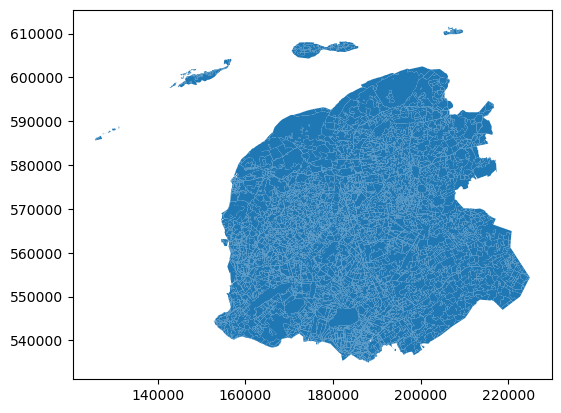

In [17]:
Wetterskip['peilgebied'].plot()

In [18]:
Wetterskip['peilgebied'] = pd.merge(left = Wetterskip['peilgebied'],
                                    right = peilgebied[['code', 'waterhoogte']],
                                    on = 'code')

Wetterskip['peilgebied'].rename(columns={'waterhoogte_x':'waterhoogte'}, inplace = True)

In [19]:
#give new globalids and codes, as the peilgebied.explode() results in non unique values.
Wetterskip['peilgebied']['code'] = 'dummy_code_peilgebied_' + Wetterskip['peilgebied'].index.astype(str)
Wetterskip['peilgebied']['globalid'] = 'dummy_globalid_peilgebied_' + Wetterskip['peilgebied'].index.astype(str)

#create the streefpeilen layer
Wetterskip['streefpeil'] = Wetterskip['peilgebied'][['waterhoogte', 'globalid', 'geometry']]
Wetterskip['peilgebied'] = Wetterskip['peilgebied'][['code', 'nen3610id', 'globalid', 'geometry']]

Wetterskip['streefpeil']['geometry'] = None

Wetterskip['streefpeil'] = gpd.GeoDataFrame(Wetterskip['streefpeil'], geometry='geometry', crs='EPSG:28992')
Wetterskip['peilgebied'] = gpd.GeoDataFrame(Wetterskip['peilgebied'], geometry='geometry', crs='EPSG:28992')


In [20]:
gemaal = gpd.read_file(gpkg_path_Wetterskip, layer = 'gemaal')
gemaal = gemaal[['code', 'nen3610id', 'globalid', 'functiegemaal', 'geometry']]
Wetterskip['gemaal'] = gemaal

In [21]:
Wetterskip['stuw']['geometry'] = Wetterskip['stuw'].centroid #prevent strange geometries
Wetterskip['gemaal']['geometry'] = Wetterskip['gemaal'].centroid #prevent strange geometries



In [22]:
#determine aanvoer en afvoer gemalen
Wetterskip['gemaal']['func_aanvoer'], Wetterskip['gemaal']['func_afvoer'], Wetterskip['gemaal']['func_circulatie']  = False, False, False #default is False
Wetterskip['gemaal']['functiegemaal'] = Wetterskip['gemaal']['functiegemaal'].astype(str) 

Wetterskip['gemaal'].loc[Wetterskip['gemaal'].functiegemaal.str.contains('Onbekend|Onderbemaling|Afvoergemaal'), 'func_afvoer'] = True
Wetterskip['gemaal'].loc[Wetterskip['gemaal'].functiegemaal.str.contains('Opmaling|Aanvoer'), 'func_aanvoer'] = True
Wetterskip['gemaal'].loc[Wetterskip['gemaal'].functiegemaal.str.contains('Overig|circulatie'), 'func_circulatie'] = True
Wetterskip['gemaal'].loc[(Wetterskip['gemaal'].func_afvoer == False) &
                       (Wetterskip['gemaal'].func_aanvoer == False) &
                       (Wetterskip['gemaal'].func_circulatie == False), 'func_afvoer'] = True #set to afvoergemaal is there the function is unknown


In [23]:
#points
Wetterskip['stuw'] = Wetterskip['stuw'][['code', 'globalid', 'nen3610id', 'geometry']]
Wetterskip['gemaal'] = Wetterskip['gemaal'][['code', 'globalid', 'nen3610id', 'func_afvoer', 'func_aanvoer', 'func_circulatie', 'geometry']]
Wetterskip['afsluitmiddel'] = Wetterskip['afsluitmiddel'][['code', 'globalid', 'nen3610id', 'geometry']]

#lines
Wetterskip['hydroobject'] = Wetterskip['hydroobject'][['code', 'globalid', 'nen3610id', 'geometry']]
Wetterskip['duikersifonhevel'] = Wetterskip['duikersifonhevel'][['code', 'globalid', 'nen3610id', 'geometry']]


In [24]:
# #delete irrelvant data
# variables = ['peilmerk', 
#              'peilgebiedpraktijk', 
#              'peilgebiedvigerend',
#              'peilbesluitgebied', 
#              'peilgebiedpraktijk']

# for variable in variables:
#     if str(variable) in Wetterskip:
#         del Wetterskip[variable]
        

In [25]:
#add duikersifonhevels to the hydroobjecten    
Wetterskip['hydroobject'] = pd.concat([Wetterskip['hydroobject'], Wetterskip['duikersifonhevel'], schouwsloten])
Wetterskip['hydroobject'] = Wetterskip['hydroobject'].drop_duplicates(subset='globalid') #in case it is run multiple times
Wetterskip['hydroobject'] = gpd.GeoDataFrame(Wetterskip['hydroobject']).set_crs('epsg:28992')


In [26]:
Wetterskip['streefpeil'].waterhoogte = Wetterskip['streefpeil'].waterhoogte.round(2)

In [27]:
Wetterskip['peilgebied']

,code,nen3610id,globalid,geometry
0,dummy_code_peilgebied_0,Oldelaamsterbrug_0,dummy_globalid_peilgebied_0,"MULTIPOLYGON Z (((189739.053 542314.424 0.000,..."
1,dummy_code_peilgebied_1,Boezem beheerst_1,dummy_globalid_peilgebied_1,"MULTIPOLYGON Z (((187468.939 543147.915 0.000,..."
2,dummy_code_peilgebied_2,Vrijafstromend_2,dummy_globalid_peilgebied_2,"MULTIPOLYGON Z (((201983.478 545854.516 0.000,..."
3,dummy_code_peilgebied_3,Boezem_3,dummy_globalid_peilgebied_3,"MULTIPOLYGON Z (((201757.882 546194.567 0.000,..."
4,dummy_code_peilgebied_4,"Fennen, De_4",dummy_globalid_peilgebied_4,"MULTIPOLYGON Z (((197494.555 553316.102 0.000,..."
...,...,...,...,...
7868,dummy_code_peilgebied_7868,Willem Jongsma_34,dummy_globalid_peilgebied_7868,"POLYGON Z ((189308.409 540865.901 0.000, 18930..."
7869,dummy_code_peilgebied_7869,Willem Jongsma_35,dummy_globalid_peilgebied_7869,"POLYGON Z ((191521.683 539320.110 0.000, 19163..."
7870,dummy_code_peilgebied_7870,Willem Jongsma_36,dummy_globalid_peilgebied_7870,"POLYGON Z ((190787.267 540064.328 0.000, 19081..."
7871,dummy_code_peilgebied_7871,Willem Jongsma_37,dummy_globalid_peilgebied_7871,"POLYGON Z ((190972.562 540027.516 0.000, 19093..."


In [28]:
show_layers_and_columns(waterschap = Wetterskip)

stuw
['code' 'globalid' 'nen3610id' 'geometry']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  epsg:28992

gemaal
['code' 'globalid' 'nen3610id' 'func_afvoer' 'func_aanvoer'
 'func_circulatie' 'geometry']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  epsg:28992

afsluitmiddel
['code' 'globalid' 'nen3610id' 'geometry']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  epsg:28992

hydroobject
['code' 'globalid' 'nen3610id' 'geometry']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  epsg:28992

duikersifonhevel
['code' 'globalid' 'nen3610id' 'geometry']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  epsg:28992

peilgebied
['code' 'nen3610id' 'globalid' 'geometry']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  epsg:28992

aggregation_area
['code' 'nen3610id' 'globalid' 'geometry' 'waterhoogte']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  epsg:28992

streefpeil
['waterhoogte' 'globalid' 'geome

In [29]:
store_data(waterschap = Wetterskip, 
           output_gpkg_path = output_gpkg_path_Wetterskip)


# Oud

In [30]:
stop

NameError: name 'stop' is not defined

In [ ]:
# layout_path = r"..\..\Data_postprocessed\QGIS_overzicht\routing_style_format3.gpkg"
# output_layout_path =  r"..\..\Data_postprocessed\QGIS_overzicht\routing_style_format2_saved"
# layout = read_gpkg_layers(gpkg_path = layout_path, 
#                         variables = ['stuw', 
#                                      'gemaal', 
#                                      'afsluitmiddel'])#,
#                                      # 'hydroobject',
#                                      # 'duikersifonhevel',
#                                      # 'streefpeil',
#                                      # 'peilgebiedpraktijk', 
#                                      # 'peilgebiedvigerend'])
# store_data(waterschap = layout, 
#            output_gpkg_path = output_layout_path)


In [ ]:
# peilgebieden_met_peil = peilgebieden_met_peil.rename(columns = {'code_left':'code',
#                                                                 'globalid_left':'globalid',
#                                                                 'nen3610id_left':'nen3610id',
#                                                                 'geometry_left':'geometry',
#                                                                 'hoogte':'waterhoogte'})
# peilgebieden_met_peil = peilgebieden_met_peil[['waterhoogte','code', 'globalid', 'nen3610id', 'geometry']].reset_index(drop=True)
# peilgebieden_met_peil = peilgebieden_met_peil.drop_duplicates(subset='globalid')

In [ ]:
# #bring the peilgebied in the correct format
# extra_peilgebied = peilgebieden_met_peil[['waterhoogte','code','globalid','nen3610id','geometry']].reset_index(drop=True)

# #bring the streefpeil in the correct format
# extra_peil = peilgebieden_met_peil[['waterhoogte', 'globalid']]
# extra_peil = extra_peil.rename(columns = {'globalid':'peilgebiedpraktijkid'})
# extra_peil['peilgebiedvigerendid'] = None
# extra_peil['geometry'] = None

# #add semi dummy globalid's and nen3610id's
# extra_peil['globalid'], extra_peil['nen3610id'] = np.arange(0, len(extra_peil)), np.arange(0, len(extra_peil))
# extra_peil['globalid'] = 'globalid_wetterskip_streefpeil_' + extra_peil['globalid'].astype(str) 
# extra_peil['nen3610id'] = 'nen3610id_wetterskip_' + extra_peil['nen3610id'].astype(str) 


In [ ]:
# #add the (geo)dataframes together
# Wetterskip['peilgebied'] = gpd.GeoDataFrame(pd.concat([peilgebied_PV, extra_peilgebied])).reset_index(drop=True)
# Wetterskip['streefpeil'] = gpd.GeoDataFrame(pd.concat([Wetterskip['streefpeil'], extra_peil])).reset_index(drop=True)

In [ ]:
# pd.merge(left=Wetterskip['streefpeil'],
#          right=peilgebied_PV,
#          left_on='peilgebiedid',
#          right_on='globalid')

In [ ]:
# Wetterskip['streefpeil']['peilgebiedid'] = None
# Wetterskip['streefpeil']['peilgebiedid'].fillna(Wetterskip['streefpeil']['peilgebiedvigerendid'], inplace = True)
# Wetterskip['streefpeil']['peilgebiedid'].fillna(Wetterskip['streefpeil']['peilgebiedpraktijkid'], inplace = True)

# #move the peilgebiedid id to both the peilgebiedenas well as the streefpeilen
# Wetterskip['peilgebied'] = gpd.GeoDataFrame()
# Wetterskip['peilgebied']['peilgebiedid'] = Wetterskip['streefpeil']['peilgebiedid'] 

# Wetterskip['peilgebied'][['code','globalid','nen3610id']] = Wetterskip['streefpeil'][['code','globalid','nen3610id',]] 


# #the peilgebieden have been merged. Drop the irrelevant columns
# Wetterskip['streefpeil'] = Wetterskip['streefpeil'][['waterhoogte', 'peilgebiedid']]#.drop(columns=['peilgebiedvigerendid', 'peilgebiedpraktijkid'], inplace = True)
# # Wetterskip['peilgebied'] = 